In [3]:
import pathlib

import pandas as pd
import stringalign
from IPython.display import HTML, display

In [4]:
data_path = pathlib.Path("data")
images_path = data_path / "images"
dataset = pd.read_json(data_path / "transcription.json")
dataset2 = pd.read_json(data_path / "microsoft.json")

In [5]:
dataset

,img,reference,predicted
0,00000.jpg,Til Bestyrelsen af,Til Bestyrelsen af
1,00001.jpg,I Ærbødighed,I Ærbødighed
2,00002.jpg,Paa Søskendes og egne Vegne,Paa Søskendas og egne Vegne
3,00003.jpg,14/7-08.,14/7-08.
4,00004.jpg,"Granskog, Hvalstad.","granskog, Hvalstad."
...,...,...,...
1557,01557.jpg,1875,1875
1558,01558.jpg,forgjæves. -,forgjæres. -
1559,01559.jpg,G. Neergaard,G. Neergaard
1560,01560.jpg,Indk 14/6 1882,Inda 14/6 1882


In [ ]:
references = dataset["reference"]
predictions = dataset["predicted"]
metadata = [{"image_path": images_path / row.img, "sample": row.Index} for row in dataset.itertuples()]

tokenizer = stringalign.tokenize.GraphemeClusterTokenizer()

transcription_evaluator = stringalign.evaluate.MultiAlignmentAnalyzer.from_strings(
    references=references,
    predictions=predictions,
    metadata=metadata,
    tokenizer=tokenizer,
)

In [7]:
# Computing the token error rate requires the string confusion matrix for all alignments.
# Creating that takes a couple of seconds, but they are all cached so all subsequent calls that require confusion matrices are very fast
cer = transcription_evaluator.compute_ter()

print(f"The CER is {cer:.3f}")

The CER is 0.060


In [8]:
num_not_unique_alignments = len(list(transcription_evaluator.not_unique_alignments))
num_differing_lines = (references != predictions).sum()
num_lines = len(predictions)

print(f"{num_differing_lines / num_lines:.0%} of the lines differ")
print(f"{num_not_unique_alignments / num_lines:.0%} of the alignments are not unique")
print(f"{num_not_unique_alignments / num_differing_lines:.0%} of the differing alignments are not unique")

55% of the lines differ
20% of the alignments are not unique
37% of the differing alignments are not unique


## Most common edits

In [9]:
combined_edits = transcription_evaluator.edit_counts["combined"].most_common(15)
raw_edits = transcription_evaluator.edit_counts["raw"].most_common(15)
pd.DataFrame(
    {
        ("Raw alignments", "Operator"): [edit_operator for edit_operator, _count in raw_edits],
        ("Raw alignments", "Count"): [count for _edit_operator, count in raw_edits],
        ("Combined alignments", "Operator"): [edit_operator for edit_operator, _count in combined_edits],
        ("Combined alignments", "Count"): [count for _edit_operator, count in combined_edits],
    }
)

Raw alignments        Combined alignments      
               Operator Count             Operator Count
0          DELETED  ' '    59         DELETED  '"'    35
1          DELETED  'e'    59         DELETED  ' '    31
2          DELETED  's'    46         DELETED  '.'    24
3          DELETED  'r'    45         DELETED  's'    24
4          INSERTED 'e'    41         DELETED  'e'    23
5          DELETED  '"'    37         INSERTED '.'    20
6   REPLACED 'a' -> 'e'    36  REPLACED 'o' -> 'a'    20
7          INSERTED ' '    36  REPLACED 'a' -> 'e'    20
8          DELETED  '.'    34  REPLACED 'i' -> 'e'    19
9   REPLACED 'o' -> 'a'    33         DELETED  ','    18
10         INSERTED 'r'    32         DELETED  'r'    17
11  REPLACED 'i' -> 'e'    27         INSERTED ','    15
12  REPLACED 'n' -> 'm'    27  REPLACED 'e' -> 'i'    14
13  REPLACED 'm' -> 'n'    27  REPLACED 't' -> 'l'    13
14  REPLACED 'A' -> 'a'    27         INSERTED 'r'    13

We see that the three most common edit in the raw alignment is deleting an `e`, inserting an `e` and deleting a space. Furthermore, if we consider consequtive edits as a single edit, then we see that there are no multi-token edit among the top 15 edits.

### Token specific statistics
We can also compute token-specific sensitivities, precisions and f1-scores to see which tokens the model struggles the most with transcribing.

,Dice,Sensitivity,Precision,Reference token count
à,1.000000,1.000000,1.000000,1.0
Q,1.000000,1.000000,1.000000,1.0
Å,1.000000,1.000000,1.000000,1.0
q,1.000000,1.000000,1.000000,3.0
,0.988215,0.986735,0.989700,7011.0
5,0.986667,1.000000,0.973684,37.0
g,0.977825,0.987733,0.968113,1875.0
f,0.970440,0.978198,0.962804,688.0
6,0.966667,0.966667,0.966667,30.0
9,0.964912,0.948276,0.982143,58.0


,Dice,Sensitivity,Precision,Reference token count
],0.0,0.0,NaN,1.0
ä,0.0,NaN,0.0,NaN
«,0.0,NaN,0.0,NaN
Þ,0.0,0.0,NaN,1.0
ù,0.0,NaN,0.0,NaN
Y,0.0,0.0,0.0,1.0
[,0.0,0.0,NaN,1.0
é,0.0,0.0,0.0,1.0
w,0.0,NaN,0.0,NaN
ö,0.0,0.0,NaN,2.0


,Dice,Sensitivity,Precision,Reference token count
c,0.814815,0.771930,0.862745,57.0
P,0.813187,0.755102,0.880952,49.0
A,0.807018,0.726316,0.907895,190.0
Æ,0.806452,0.757576,0.862069,33.0
O,0.794326,0.691358,0.933333,81.0
;,0.787879,0.764706,0.812500,17.0
L,0.779221,0.697674,0.882353,86.0
Ø,0.769231,0.714286,0.833333,14.0
"""",0.765957,0.652174,0.927835,138.0
R,0.756757,0.691358,0.835821,81.0


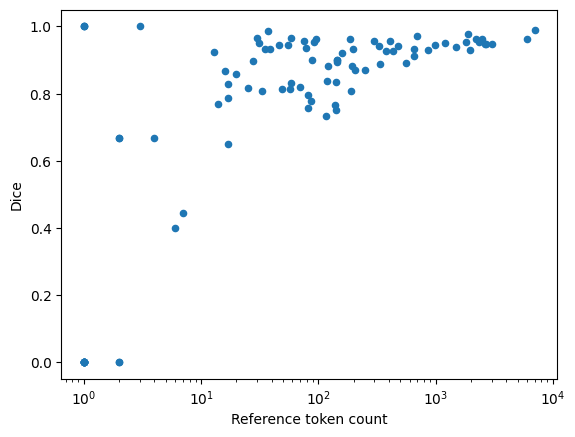

In [ ]:
cm = transcription_evaluator.confusion_matrix
dice = cm.compute_dice()
sensitivity = cm.compute_sensitivity()
precision = cm.compute_precision()
token_counts = cm.true_positives + cm.false_negatives


token_statistics = pd.DataFrame(
    {"Dice": dice, "Sensitivity": sensitivity, "Precision": precision, "Reference token count": token_counts}
)

tokens_occuring_more_than_10_times = [token for token, cnt in token_counts.items() if cnt > 5]
token_statistics_without_uncommon_tokens = token_statistics.loc[tokens_occuring_more_than_10_times].sort_values(
    "Dice", ascending=False
)

display(HTML("<h5>Top 15 tokens with the highest Dice score</h5>"))
display(token_statistics.head(15))


display(HTML("<h5>Bottom 15 tokens with the lowest Dice score</h5>"))
display(token_statistics.tail(15))

display(
    HTML(
        "<h5>Bottom 15 tokens with the lowest Dice score among tokens occuring at least 10 times in the references</h5>"
    )
)
display(token_statistics_without_uncommon_tokens.tail(15))


ax = token_statistics.plot(x="Reference token count", y="Dice", kind="scatter")
ax.set_xscale("log")

## Lines with the highest CER

In [ ]:
analyzers = sorted(
    transcription_evaluator.alignment_analyzers, key=stringalign.evaluate.AlignmentAnalyzer.compute_ter, reverse=True
)

for alignment_analyzer in analyzers[:15]:
    sample = alignment_analyzer.metadata["sample"]
    base64_html_img_tag = stringalign.visualize.create_html_image(alignment_analyzer.metadata["image_path"])
    alignment_html = alignment_analyzer.visualize()
    row = HTML(f"""<div><h5>Transcription {sample}</h5>{base64_html_img_tag}{alignment_html}</div>""")
    display(row)

## Inspecting suspected horisontal segmentation errors

By inspecting suspected horisontal segmentation errors we can discover potential errors in the data. That is, samples where there are errors in the beginning or end of the string. In this case, we see that there are no horisontal segmentation errors, but among the first ten lines there is punctuation in the reference for one of them (transcription 67).

In [12]:
num_samples = 10
for alignment_analyzer, _ in zip(transcription_evaluator.horisontal_segmentation_errors, range(num_samples)):
    sample = alignment_analyzer.metadata["sample"]
    base64_html_img_tag = stringalign.visualize.create_html_image(alignment_analyzer.metadata["image_path"])
    alignment_html = alignment_analyzer.visualize()
    row = HTML(f"""<div><h5>Transcription {sample}</h5>{base64_html_img_tag}{alignment_html}</div>""")
    display(row)